### Import Libraries

In [1]:
# Import necessary libraries for our RAG application and teaching agent
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
import glob
import matplotlib.pyplot as plt  # For plotting graphs
import time  # For timing stages

print("Libraries imported successfully!")

Libraries imported successfully!


###  Setup Environment and LLM

In [2]:
# Step 1: Setup Environment and LLM
# This is like setting up your classroom with the right tools
def setup_environment():
    load_dotenv()
    if not os.getenv("GROQ_API_KEY"):
        raise ValueError("Please set GROQ_API_KEY in your .env file!")
    llm = ChatGroq(model="llama-3.3-70b-versatile")
    print("Environment setup complete. Your AI teacher is ready!")
    return llm

In [2]:
# Step 2: Load Documents from Any Code Folder
# Simplified version with optimized chunk size
import os
import glob
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import re

def generate_tree_structure(directory):
    """Generate a textual representation of the directory tree."""
    tree = []
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = '  ' * level
        tree.append(f"{indent}{os.path.basename(root)}/")
        for f in files:
            tree.append(f"{indent}  {f}")
    return "\n".join(tree)

def infer_code_flow(files, directory):
    """Basic inference of code flow by looking at imports/requires."""
    flow = []
    import_patterns = {
        'py': r"import\s+[\w.]+\s*(?:as\s+\w+)?|from\s+[\w.]+\s+import\s+[\w.*]+",
        'js': r"import\s+.*?\s+from\s+['\"].*?['\"]|require\(['\"].*?['\"]\)",
        'jsx': r"import\s+.*?\s+from\s+['\"].*?['\"]|require\(['\"].*?['\"]\)"
    }
    
    for file_path in files:
        ext = file_path.rsplit('.', 1)[-1] if '.' in file_path else ''
        if ext in import_patterns:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                imports = re.findall(import_patterns[ext], content)
                if imports:
                    rel_path = os.path.relpath(file_path, directory)
                    flow.append(f"{rel_path} depends on:")
                    for imp in imports:
                        flow.append(f"  - {imp.strip()}")
            except Exception as e:
                flow.append(f"Error analyzing {file_path}: {e}")
    return "\n".join(flow) if flow else "No detectable dependencies found."

def load_documents(directory="code_folder"):
    """Load code files, tree, and flow from the directory."""
    # Verify directory exists
    abs_dir = os.path.abspath(directory)
    if not os.path.isdir(abs_dir):
        print(f"Error: Directory '{abs_dir}' does not exist!")
        return []
    print(f"Scanning directory: {abs_dir}")

    # Define supported extensions
    extensions = ("py", "js", "jsx", "ts", "java", "c", "cpp", "cs", "go", "rs", 
                  "php", "rb", "sh", "txt", "md", "html", "css", "yaml", "yml", "conf")
    glob_pattern = "**/*.{" + ",".join(extensions) + "}"
    print(f"Using glob pattern: {glob_pattern}")

    # Find all matching files
    matching_files = []
    for ext in extensions:
        matching_files.extend(glob.glob(os.path.join(directory, f"**/*.{ext}"), recursive=True))
    print(f"Found {len(matching_files)} files:")
    for file in matching_files[:5]:
        print(f"  {file}")
    if len(matching_files) > 5:
        print(f"  ...and {len(matching_files) - 5} more")

    # Load documents
    documents = []
    for file_path in matching_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            doc = Document(page_content=content, metadata={"source": os.path.relpath(file_path, directory)})
            documents.append(doc)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")

    # Add tree structure
    tree_content = generate_tree_structure(directory)
    documents.append(Document(page_content=tree_content, metadata={"source": "directory_tree.txt"}))

    # Add code flow
    flow_content = infer_code_flow(matching_files, directory)
    documents.append(Document(page_content=flow_content, metadata={"source": "code_flow.txt"}))

    # Debug: Count files per subfolder
    subfolders = set()
    for doc in documents:
        source = doc.metadata.get("source", "")
        if source not in ["directory_tree.txt", "code_flow.txt"]:
            subfolder = os.path.dirname(source)
            subfolders.add(subfolder if subfolder else "root")

    print(f"Loaded {len(documents)} files across {len(subfolders)} subfolders:")
    for subfolder in sorted(subfolders):
        if subfolder == "root":
            file_count = sum(1 for doc in documents 
                            if "/" not in doc.metadata.get("source", "") 
                            and doc.metadata["source"] not in ["directory_tree.txt", "code_flow.txt"])
        else:
            file_count = sum(1 for doc in documents 
                            if doc.metadata.get("source", "").startswith(subfolder + "/") 
                            and doc.metadata["source"] not in ["directory_tree.txt", "code_flow.txt"])
        if file_count > 0:
            print(f"  {subfolder}: {file_count} files")

    # Split into chunks with optimized size
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(documents)
    print(f"Loaded {len(documents)} files, split into {len(split_docs)} chunks")
    return split_docs

# # Test with otter-detection
# sample_dir = "otter-detection"
# print(f"Testing with directory: {sample_dir}")
# docs = load_documents(sample_dir)

# # Verify
# assert len(docs) > 0, f"No documents loaded from {sample_dir}! Check directory and permissions."
# subfolder_count = len(set(os.path.dirname(doc.metadata.get("source", "")) for doc in docs 
#                          if doc.metadata["source"] not in ["directory_tree.txt", "code_flow.txt"]))
# print(f"Test passed: Loaded {len(docs)} chunks from {subfolder_count} subfolder(s).")

In [4]:
# Step 3: Create Vector Store
# This is like building a library index for quick reference
def create_vector_store(docs, persist_dir="./chroma_db"):
    embeddings = OllamaEmbeddings(
        model="mxbai-embed-large",
        # base_url="http://localhost:11434"  # Ensure Ollama is running
    )
    vector_store = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        persist_directory=persist_dir
    )
    print(f"Vector store created at {persist_dir}")
    return vector_store

In [ ]:
# Step 4: Define Application State and Enhanced Agent
# This is the student's notebook, tracking progress through the development lifecycle
class AgentState(TypedDict):
    query: str
    documents: List[Document]
    response: str
    stage: str  # Track development stage (e.g., planning, coding, testing)
    test_results: List[bool]  # Store test outcomes


def teaching_agent(state: AgentState, llm):
    stages = ["Planning", "Coding", "Testing", "Deployment"]
    if "stage" not in state or not state["stage"]:
        state["stage"] = stages[0]  # Start with Planning
    
    context = "\n\n".join([doc.page_content for doc in state["documents"]]) if state["documents"] else ""
    
    prompt = f"""
    **Role**: You are an expert software architect and educator specializing in codebase analysis and explanation.
    
    **Current Development Stage**: {state['stage']}
    
    **User Query Analysis**:
    - Original query: "{state['query']}"
    - Interpreted intent: [Your interpretation of what the user really needs to know]
    
    **Code Context Analysis**:
    {context if context else "No relevant code context found"}
    
    **Task Requirements**:
    1. Architectural Breakdown:
       - Identify key components/modules in the codebase
       - Explain their relationships and data flow
       - Highlight any design patterns used
    
    2. Stage-Specific Guidance:
       {{
       "Planning": "Focus on overall architecture and requirements",
       "Coding": "Explain implementation details and best practices",
       "Testing": "Highlight testable components and suggest test cases",
       "Deployment": "Discuss deployment considerations and infrastructure"
       }}[{state['stage']}]
    
    3. User-Level Adaptation:
       - Assess the user's likely skill level based on their query
       - Adjust technical depth accordingly
       - Use analogies where helpful
    
    **Response Format**:
    - Start with 1-sentence summary
    - Then provide detailed breakdown
    - End with actionable next steps
    
    **Special Instructions**:
    - Never say "based on the context" or similar phrases
    - If information is incomplete, state what's missing
    - Use markdown formatting for code blocks and lists
    """
    
    response = llm.invoke(prompt)
    return {
        "response": response.content,
        "stage": state["stage"],
        "test_results": state.get("test_results", [])
    }

In [6]:
# Step 5: Test Code and Progress Stages
def test_stage(state: AgentState, llm):
    if state["stage"] == "Testing":
        test_prompt = f"Given this code context:\n{state['response']}\nSuggest and evaluate a test case."
        test_response = llm.invoke(test_prompt)
        test_passed = "pass" in test_response.content.lower()  # Simple heuristic
        state["test_results"].append(test_passed)
        print(f"Test result: {'Passed' if test_passed else 'Failed'}")
    return state

def next_stage(state: AgentState):
    stages = ["Planning", "Coding", "Testing", "Deployment"]
    current_idx = stages.index(state["stage"])
    if current_idx < len(stages) - 1:
        state["stage"] = stages[current_idx + 1]
        print(f"Moving to stage: {state['stage']}")
    return state

In [7]:
code_directory="otter-detection"
persist_dir="./chroma_db"
if not os.path.exists(persist_dir):
    docs = load_documents(code_directory)
    if docs:
        create_vector_store(docs, persist_dir)
    else:
        print("No code files found!")

Scanning directory: /home/saurabh-nitro/projects/AgenticAI/CodeExplorerRAG/otter-detection
Using glob pattern: **/*.{py,js,jsx,ts,java,c,cpp,cs,go,rs,php,rb,sh,txt,md,html,css,yaml,yml,conf}
Found 71 files:
  otter-detection/src/main.py
  otter-detection/src/decoder.py
  otter-detection/src/server.py
  otter-detection/src/analyse.py
  otter-detection/src/tracker.py
  ...and 66 more
Loaded 73 files across 18 subfolders:
  nginx: 1 files
  root: 2 files
  server/static/devel: 39 files
  server/static/devel/src: 37 files
  server/static/devel/src/live: 8 files
  server/static/devel/src/live/unused: 3 files
  server/static/devel/src/monitor: 4 files
  server/static/devel/src/mwc: 9 files
  server/static/devel/src/recorder: 9 files
  server/static/devel/src/recorder/unused: 1 files
  src: 11 files
  src/fan_controller: 1 files
  src/recorder: 2 files
  static: 18 files
  static/assets: 2 files
  static/recorder: 11 files
  static/recorder/unused: 6 files
  static/recorder/unused/lib: 3 file

In [ ]:
from langchain.tools.retriever import create_retriever_tool

def load_chroma_retriever(persist_dir: str = "./chroma_db"):
    embeddings = OllamaEmbeddings(
        model="mxbai-embed-large",
    )

    vector_store = Chroma(
        persist_directory=persist_dir,
        embedding_function=embeddings
    )
    
    return vector_store.as_retriever()

# Initialize the retriever tool
retriever = load_chroma_retriever()
retriever_tool = create_retriever_tool(
    retriever,
    "codebase_retriever",
    "Search for information about the codebase architecture and implementation"
)

In [29]:
# Step 6: Build the Workflow
# This is the lesson plan, guiding you through the lifecycle
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
def build_workflow(llm):
    workflow = StateGraph(AgentState)
    
    # Modified retrieve node to maintain Document structure
    workflow.add_node("retrieve", lambda state: {
        "documents": [
            Document(page_content=content) 
            for content in retriever_tool.run(state["query"]).split("\n\n")  # Simple split, adjust as needed
        ]
    })
    
    # Rest of your workflow remains the same
    workflow.add_node("teach", lambda state: teaching_agent(state, llm))
    # workflow.add_node("test", lambda state: test_stage(state, llm))
    # workflow.add_node("progress", next_stage)
    
    # workflow.set_entry_point("retrieve")
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "teach")
    workflow.add_edge("teach", END)
    # workflow.add_edge("test", "progress")
    # workflow.add_conditional_edges(
    #     "progress",
    #     lambda state: END if state["stage"] == "Deployment" else "retrieve"
    # )
    
    graph =  workflow.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    
    return graph



# # Test workflow setup
# workflow = build_workflow(llm, "./chroma_db")
# print("Workflow built successfully!")


In [30]:
llm = setup_environment()

Environment setup complete. Your AI teacher is ready!


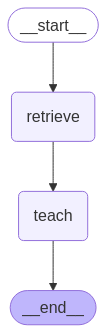

In [31]:
app = build_workflow(llm)

In [34]:

# Step 7: Run the Application with Progress Tracking
def run_app(query: str):
    state = {"query": query, "test_results": []}
    stages_completed = []
    times = []
    start_time = time.time()

    state = app.invoke(state)
    stages_completed.append(state["stage"])
    times.append(time.time() - start_time)
    print(f"\nStage: {state['stage']}\nResponse: {state['response']}")

    return state, stages_completed, times

In [35]:
# Run with a sample query
query = "tell me about the react code in databse, how its working"
code_dir = "otter-detection"
final_state, stages, times = run_app(query)


Stage: Planning
Response: ## Overview of the React Code

The provided React code is a collection of components that seem to be part of a larger application for displaying and analyzing data from a database, specifically InfluxDB. The components include:

1. `DataChart`: A chart component that displays data from InfluxDB.
2. `DataGridAndChart`: A component that combines a data grid and a chart.
3. `DataGrid`: A component that displays data in a grid format.
4. `Thumbnail`: A component that displays a thumbnail image with overlay text.

## How the Code Works

1. **DataChart**: This component uses the `AgCharts` library to create a chart. It fetches data from InfluxDB using the `queryInflux` function and updates the chart with the fetched data. The chart displays data for a specific field and duration.
2. **DataGridAndChart**: This component combines a data grid and a chart. It uses the `DataGrid` and `DataChart` components and passes props to them. It also handles state changes for the 

In [ ]:
# # Step 8: Plot Progress Graph
# # Visualize how long each stage took
# plt.figure(figsize=(10, 6))
# plt.plot(stages, times, marker='o', linestyle='-', color='b')
# plt.title("Software Development Lifecycle Progress")
# plt.xlabel("Stage")
# plt.ylabel("Time (seconds)")
# plt.grid(True)
# plt.show()

# # Display test results
# print("\nTest Results:")
# for i, result in enumerate(final_state["test_results"]):
#     print(f"Test {i+1}: {'Passed' if result else 'Failed'}")